In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline

### Lyrics analysis project
We have a dataset containing 380,000+ song lyrics, from different artists, years and genre. First lets get to know the data. 

My first goal in any project is to get to 'know' the data. Lets read it in and take a look at the dataframe.

##### First we will read in our dataframe using pandas built in csv reader 


In [13]:
df = pd.read_csv('../data/lyrics.csv')\
       .drop('index',axis=1)

df.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


###### Some descriptive plots

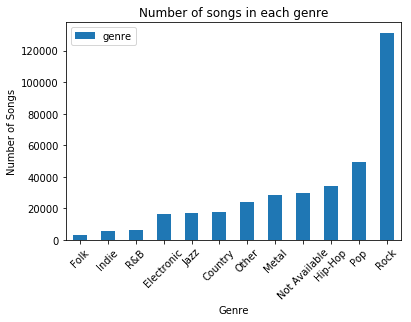

In [27]:
df.groupby('genre')\
  .agg({'genre':len})\
  .sort_values('genre')\
  .plot(kind='bar', rot=45)
plt.title("Number of songs in each genre")
plt.ylabel('Number of Songs')
plt.xlabel('Genre')
plt.show()

We have a class imbalance! If genre is going to be a dependent variable don't forget to use stratified sampling!

In [12]:
for col in df.columns:
    unq  = df[col].unique().shape[0]
    null = df[col].isnull().sum()
    print('\'%s\' column has %i unique entries and %i nulls.'%(col,unq,null))

'song' column has 250473 unique entries and 2 nulls.
'year' column has 52 unique entries and 0 nulls.
'artist' column has 18231 unique entries and 0 nulls.
'genre' column has 12 unique entries and 0 nulls.
'lyrics' column has 244874 unique entries and 95680 nulls.


###### Lets take a look at some lyrical data!

In [77]:
print(df.iloc[21].lyrics)

Beyonc - Intro:
Beyonce
IAM
Welcome
Welcome
Hey
Ohhhh
Beyonc - Chorus:
Welcome to a place
Where people lie to your face
Just to get it done.
Welcome to the human race
Where if you ain't got money, then you'll pay in pain
Welcome to this world of ours
And if you had the chance would you come back again ?
Cause now you're here there ain't no turning back,
You got tears in your eyes
And the monkey on your back (?)*
Akhenaton - Verse 1:
Bienvenue l o l'fort tue le faible, o la faim tue de fait
O la socit t'congratule, et t'accepte une fois la fortune faite,
O les dettes cumulent, o l'crdit accule, des tas d'foyers,
O les hommes en perte d'idaux, jurent qu'par les putes dvoyes en vido,
Chaque soir c'est la fte, les salons cossus attirent les fesses,
Sur les gros cads, qui arrosent les guridons de pure cocane,
Ici, les gosses rvent d't'Pirs, beaucoup partent et peu qui restent,
Nombreux sont ceux qui ds 13 ans connaissent leur premire ivresse,
Bienvenue l o l'air pollu, par les pots d'chappe

###### The challange 

Do some feature engineering! Code up some custom transformers that can be plugged into an sklearn pipline and transform our data into model features!   I created a couple to get you started.

In [224]:
import numpy as np
from sklearn import base 
from sklearn import pipeline

In [238]:
df=df[~df.lyrics.isnull()]


class YearVectorizer(base.BaseEstimator, base.TransformerMixin):
    """
    An Example custom transformer!
    YearVectorizer takes the 'year' column of a dataframe and
    one-hot-encodes it. Can you make it better? 
    Impute missing values?
    Encode decade instead of year?
    """
    def __init__(self, colName):
        self.colName = colName
        self._tansformer = sklearn.preprocessing.LabelBinarizer()
        
    def fit(self, X, *_):
        self._tansformer.fit(X[self.colName])
        return self
    
    def transform(self, X, *_):
        return self._tansformer.transform(X[self.colName])
        
    def fit_transform(self,X, *_):
        self.fit(X)
        return self.transform(X)
        

class WordCount(base.BaseEstimator,base.TransformerMixin):
    """
    An Example custom transformer!
    WordCount takes the 'lyrics' column returns the number of words
    in the song.
    Can you make it better?
    Count the number of unique words instead?
    """
    def __init__(self, colName):
        self.colName = colName
        
    def fit(self, X, *_): return self
    
    def transform(self, X, *_):
        return np.atleast_2d(X[self.colName].apply(lambda x: len(x.split(' ')))).T

    def fit_transform(self,X, *_):
        return self.transform(X)

#How about one encoding average word size? Number of sylabols?

###### Lets test out the word count custom transformer

In [226]:
year_ft = YearVectorizer('year')

year_ft.fit(df)
year_ft.transform(df)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

###### Feature Union
To use the features engineered by WordCount & YearVectorizer in the same pipeline we will need to use FeatureUnion

In [227]:
featUnion = pipeline.FeatureUnion([ 
                             ('yv',YearVectorizer('year')),
                             ('wc',WordCount('lyrics'))
                    
                          ])



featUnion.fit_transform(df.iloc[0:200])

array([[  0,   0,   1, ...,   0,   0, 384],
       [  0,   0,   1, ...,   0,   0, 220],
       [  0,   0,   1, ...,   0,   0, 116],
       ..., 
       [  0,   0,   0, ...,   0,   0, 341],
       [  0,   0,   0, ...,   0,   0, 436],
       [  0,   0,   0, ...,   0,   0, 407]])

##### Now its time for TFIDF!

see: sklearn.feature_extraction.text.TfidfVectorizer


Take a look at the paramters and create a couple of custom transformers by specifiying your own tokenizer and preprocessor. How would you add this to our featUnion pipeline? We will find the best one via grid search!

In [235]:
tfid=sklearn.feature_extraction.text.TfidfVectorizer(max_features=500)

In [237]:
tfid.fit_transform(df.lyrics)

<266557x500 sparse matrix of type '<class 'numpy.float64'>'
	with 14827763 stored elements in Compressed Sparse Row format>